In [3]:
import numpy as np
import keras
import os
from pathlib import Path


In [4]:
obatch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = os.path.join("ukr.txt")



In [5]:
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype="float32",
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype="float32",
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype="float32",
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

Number of samples: 10000
Number of unique input tokens: 72
Number of unique output tokens: 96
Max sequence length for inputs: 15
Max sequence length for outputs: 54


In [13]:
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [15]:
batch_size = 128  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)
# Save model
model.save("s2s_model.keras")


Epoch 1/100
63/63 [==============================] - 4s 22ms/step - loss: 0.0311 - accuracy: 0.9878 - val_loss: 0.9132 - val_accuracy: 0.8614
Epoch 2/100
63/63 [==============================] - 1s 12ms/step - loss: 0.0288 - accuracy: 0.9882 - val_loss: 0.9145 - val_accuracy: 0.8615
Epoch 3/100
63/63 [==============================] - 1s 11ms/step - loss: 0.0284 - accuracy: 0.9883 - val_loss: 0.9196 - val_accuracy: 0.8610
Epoch 4/100
63/63 [==============================] - 1s 11ms/step - loss: 0.0282 - accuracy: 0.9883 - val_loss: 0.9252 - val_accuracy: 0.8607
Epoch 5/100
63/63 [==============================] - 1s 11ms/step - loss: 0.0280 - accuracy: 0.9882 - val_loss: 0.9219 - val_accuracy: 0.8608
Epoch 6/100
63/63 [==============================] - 1s 11ms/step - loss: 0.0279 - accuracy: 0.9882 - val_loss: 0.9234 - val_accuracy: 0.8610
Epoch 7/100
63/63 [==============================] - 1s 11ms/step - loss: 0.0276 - accuracy: 0.9882 - val_loss: 0.9226 - val_accuracy: 0.8620
Epoch 

In [16]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
model = keras.models.load_model("s2s_model.keras")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq, verbose=0)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value, verbose=0
        )

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence


In [17]:
for seq_index in range(2080, 2100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)


-
Input sentence: Is this it?
Decoded sentence: Це він?
-
Input sentence: Is this it?
Decoded sentence: Це він?
-
Input sentence: It happens.
Decoded sentence: Таке трапляється.
-
Input sentence: It happens.
Decoded sentence: Таке трапляється.
-
Input sentence: It is 7:45.
Decoded sentence: Зараз чверть на восьму.
-
Input sentence: It matters.
Decoded sentence: Він має значення.
-
Input sentence: It matters.
Decoded sentence: Він має значення.
-
Input sentence: It was Tom.
Decoded sentence: Це був Том.
-
Input sentence: It was bad.
Decoded sentence: Все пройшло погано.
-
Input sentence: It was bad.
Decoded sentence: Все пройшло погано.
-
Input sentence: It was big.
Decoded sentence: Вона була великою.
-
Input sentence: It was big.
Decoded sentence: Вона була великою.
-
Input sentence: It was fun.
Decoded sentence: Він був поганий.
-
Input sentence: It was hot.
Decoded sentence: Було спекотно.
-
Input sentence: It was sad.
Decoded sentence: Було сумно.
-
Input sentence: It went OK.
Deco

In [23]:
from transformers import pipeline, AutoTokenizer, AutoModelForQuestionAnswering
model_name = "robinhad/ukrainian-qa"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForQuestionAnswering.from_pretrained(model_name)

qa_model = pipeline("question-answering", model=model.to("cpu"), tokenizer=tokenizer)
question = "Коли проголошена конституція України?"
context = """Верховна Рада України від імені Українського народу - громадян України всіх національностей,
виражаючи суверенну волю народу, спираючись на багатовікову історію українського державотворення і на основі здійсненого українською нацією, усім Українським народом права на самовизначення, дбаючи про забезпечення прав і свобод людини та гідних умов її життя,
 піклуючись про зміцнення громадянської злагоди на землі України та підтверджуючи європейську ідентичність Українського народу і незворотність європейського та євроатлантичного курсу України, прагнучи розвивати і зміцнювати демократичну, соціальну, правову державу, усвідомлюючи відповідальність перед Богом, власною совістю, попередніми, нинішнім та прийдешніми поколіннями, керуючись Актом проголошення незалежності України від 24 серпня 1991 року, схваленим 1 грудня 1991 року всенародним голосуванням, приймає цю Конституцію - Основний Закон України."""
qa_model(question = question, context = context)

{'score': 0.5200613141059875,
 'start': 783,
 'end': 804,
 'answer': ' 24 серпня 1991 року,'}

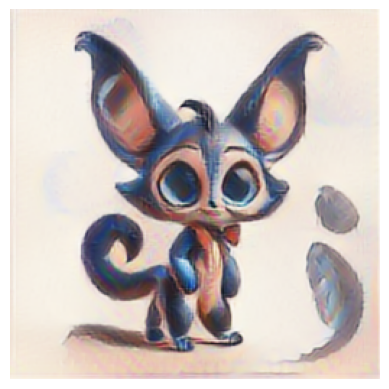

In [28]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np

def load_image(image_path, image_size=(256, 256)):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, image_size)
    img = img[tf.newaxis, :]
    return img

def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return tensor

# Replace with your own image path and style model URL
image_path = "original_image.jpg"
style_model_url = "https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2"

# Load the image
content_image = load_image(image_path)

# Load the pre-trained style transfer model
style_transfer_model = hub.load(style_model_url)

# Perform style transfer (you can replace 'content_image' with a style image of your choice)
stylized_image = style_transfer_model(tf.constant(content_image), tf.constant(content_image))[0]

# Convert tensor to image and display
image = tensor_to_image(stylized_image)
plt.imshow(image)
plt.axis('off')
plt.show()

